# Overview {#sec-pca}

In this notebook, we will use Principal Component Analysis (PCA) to identify the most relevant planes (components) of effort among the features in the dataset(s) we created in the previous script. We do this paralel to eXtreme Gradient Boosting (XGBoost, see [script here](../08_Analysis_XGBoost/02_XGBoost_effortIndicators.qmd#sec-xgboost)) because unlike PCA, XGBoost does not prevent from cummulating most relevant features that are correlated, i.e., they likely explain similar dimension of effort. To increase interpretative power of our analysis, we will combine these two methods to identify the most relevant features within the most relevant dimensions (i.e., components) of effort.

Note that the current version of the script is used with data only from dyad 0. Since this is not sufficient amount of data for any meaningful conclusions, this script serves for building the workflow. We will use identical pipeline with the full dataset, and any deviations from this script will be reported.


In [ ]:
#| code-fold: true
#| code-summary: Code to prepare the environment

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

curfolder = os.getcwd()

# This is where our features live
features = curfolder + '\\..\\07_TS_featureExtraction\\Datasets\\'
dfs = glob.glob(features + '*.csv') 


Because within the three distinct modalities - gesture, vocalization, combined - a set of different components could be decisive to characterize effort, we will perform PCA on each modality separately.

In [4]:
# This is gesture data
ges = [x for x in dfs if 'gesture' in x]
data_ges = pd.read_csv(ges[0])

# This is vocalization data
voc = [x for x in dfs if 'vocal' in x]
data_voc = pd.read_csv(voc[0])

# This is multimodal data
multi = [x for x in dfs if 'combination' in x]
data_multi = pd.read_csv(multi[0])

# PCA: Gesture

Let's start by cleaning the dataframe. In gesture modality, some of the features are not relevant to the current analysis - those are mainly the ones that are related to acoustics and concept-related information. We will remove them from the dataframe before performing PCA.

In [ ]:
#| code-fold: true
#| code-summary: Custom functions

# Function to clean the data
def clean_df(df, colstodel):

    # Delete all desired columns
    df = df.loc[:,~df.columns.str.contains('|'.join(colstodel))]

    # Fill NaNs with 0
    df = df.fillna(0)   # FLAGGED: this we might change, maybe not the best method (alternative: MICE)

    # Save values from correction_info
    correction_info = df['correction_info']

    # Leave only numerical cols, except correction_info
    df = df.select_dtypes(include=['float64','int64'])

    # Add back correction_info
    df['correction_info'] = correction_info
    
    return df

In [7]:
# These are answer related columns
conceptcols = ['answer', 'expressibility', 'response']

# These are vocalization related columns
voccols = ['envelope', 'audio', 'f0', 'f1', 'f2', 'f3', 'env_', 'duration_voc', 'CoG']

# Concatenate both lists
colstodel = conceptcols + voccols

# Clean the df
ges_clean = clean_df(data_ges, colstodel)

ges_clean.head(15)

,arm_duration,arm_inter_Kin,arm_inter_IK,arm_bbmv,lowerbody_duration,lowerbody_inter_Kin,lowerbody_inter_IK,lowerbody_bbmv,leg_duration,leg_inter_Kin,...,arm_asymmetry,arm_moment_sum_pospeak_mean,arm_power_pospeak_std,pelvis_moment_sum_change_pospeak_std,pelvis_moment_sum_pospeak_std,arm_moment_sum_pospeak_std,lowerbody_moment_sum_pospeak_std,lowerbody_power_pospeak_std,leg_moment_sum_change_pospeak_std,correction_info
0,3816.0,28.001,29.471,10.348,3244.0,27.815,30.057,9.607,3244.0,27.788,...,-2481.688,-8.489,1.030,0.000,0.646,4.579,0.303,0.000,0.000,c0_only
1,5280.0,28.098,30.942,13.350,5862.0,28.648,31.235,17.882,5862.0,29.740,...,-2803.359,-0.430,1.682,0.213,0.907,1.201,0.409,0.000,0.513,c0_only
2,4302.0,28.401,31.164,10.572,4206.0,28.373,31.096,8.402,4206.0,27.451,...,-6703.803,-6.312,0.348,0.000,1.403,3.175,1.227,0.000,0.000,c0
3,4474.0,27.316,30.376,10.229,4398.0,28.390,32.196,9.064,4398.0,27.665,...,-2827.356,-5.724,1.266,0.000,1.717,5.321,0.124,0.000,0.000,c1
4,4388.0,27.872,31.225,9.748,3782.0,27.458,30.479,8.428,3782.0,27.529,...,-3711.104,-1.685,0.000,0.012,1.045,3.724,0.270,0.000,0.000,c2
5,5852.0,29.417,32.048,10.675,5404.0,29.153,30.545,10.334,5404.0,29.056,...,-8208.505,-8.680,2.553,0.018,0.958,2.077,0.145,0.000,0.000,c0_only
6,2736.0,26.324,27.656,6.547,0.0,0.000,0.000,0.000,0.0,0.000,...,-3005.988,0.645,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c0
7,4256.0,28.675,29.776,8.148,0.0,0.000,0.000,0.000,0.0,0.000,...,-3988.156,-5.168,0.000,0.000,1.373,8.906,0.000,0.000,0.000,c1
8,2516.0,26.234,27.815,7.774,884.0,23.300,25.890,6.598,884.0,23.423,...,-6191.330,-2.486,0.000,0.000,0.909,4.152,0.000,0.000,0.000,c0_only
9,4504.0,28.604,30.892,9.939,4266.0,27.764,29.475,11.045,4266.0,28.404,...,-9892.382,-5.280,1.533,0.000,0.688,1.350,0.390,0.356,0.000,c0


<br>
Now, we first standardize the data and apply PCA to extract principal components. We use custom function `PCA_biplot` (adapted from [here](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)) to visualize the first two principal components. Data points are color-coded on the target variable (correction info) and red arrows represent the contributions of selected variables to the PC.

In [ ]:
#| code-fold: true
#| code-summary: Custom functions

# Function to plot PCA results
def PCA_biplot(score, coeff, labels=None, selected_vars=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    # Ensure all arrays have the same length
    min_length = min(len(xs), len(ys), len(y))

    # Trim all arrays to the smallest length
    xs_trimmed = xs[:min_length]
    ys_trimmed = ys[:min_length]
    y_trimmed = y[:min_length]  # Adjust 'c' values to match

    
    plt.figure(figsize=(12, 8))  # Increase figure size
    # Now plot safely
    plt.scatter(xs_trimmed * scalex, ys_trimmed * scaley, c=y_trimmed, cmap="viridis", alpha=0.7)
    
    # If selected_vars is provided, only plot these variables
    if selected_vars is not None:
        for i in selected_vars:
            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
            if labels is None:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), 
                         color='g', ha='center', va='center', fontsize=9)
            else:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], 
                         color='g', ha='center', va='center', fontsize=9)
    else:
        for i in range(n):
            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
            if labels is None:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), 
                         color='g', ha='center', va='center', fontsize=9)
            else:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], 
                         color='g', ha='center', va='center', fontsize=9)

    # Zoom into the plot by narrowing the axis limits
    plt.xlim(-0.5, 0.5)  # Adjust the range as needed
    plt.ylim(-0.5, 0.5)  # Adjust the range as needed
    
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.grid()
    plt.title("PCA Biplot", fontsize=16)
    plt.show()

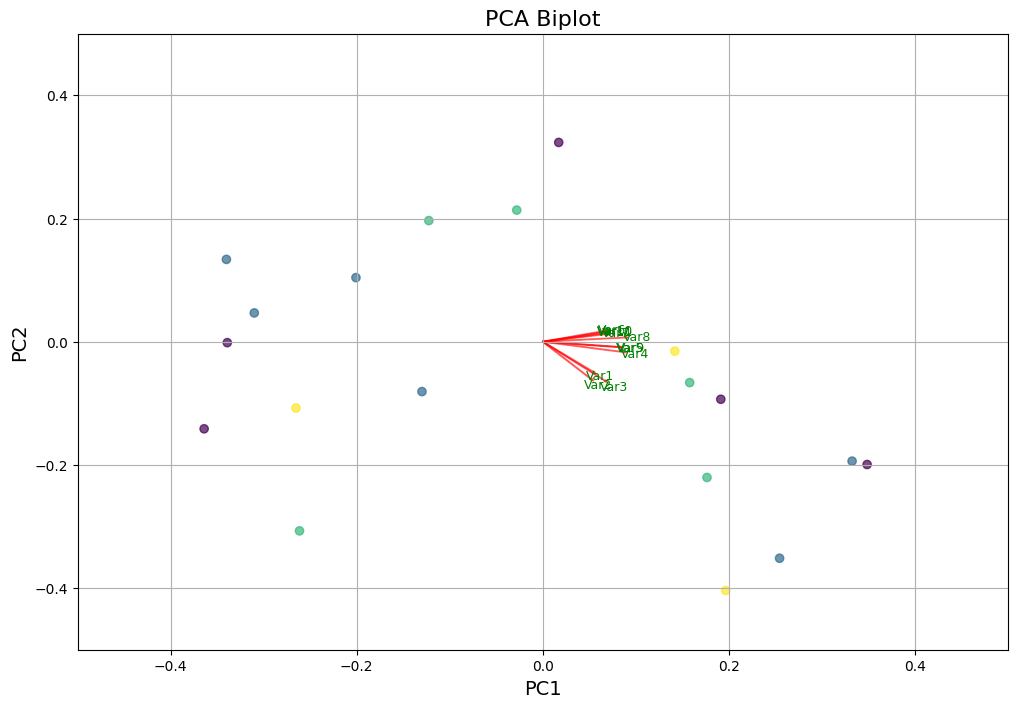

In [ ]:
# Prepare data
X = ges_clean.iloc[:, :-1].values  # All columns except the last as features
y = ges_clean.iloc[:, -1].values   # Last column as target variable

# Convert categorical target to numeric if necessary
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)  # Converts categorical labels into numeric labels

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)    

# PCA transformation
pca = PCA()
x_new = pca.fit_transform(X)

# For intelligibility, let's select only plot some variables
selected_vars = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  

# Call the function. Use only the 2 PCs.
PCA_biplot(x_new[:, 0:2], np.transpose(pca.components_[0:2, :]), selected_vars=selected_vars)


<br>
What amount of variances each PC explains?

In [ ]:
#| echo: false

pca.explained_variance_ratio_

array([3.84511094e-01, 1.33517247e-01, 1.13255439e-01, 7.31860616e-02,
       4.06776991e-02, 3.60648304e-02, 3.37781522e-02, 2.58262475e-02,
       2.25049502e-02, 2.11170841e-02, 1.88455453e-02, 1.63285979e-02,
       1.42102152e-02, 1.37325090e-02, 1.14525593e-02, 1.05874031e-02,
       9.39941422e-03, 8.83676344e-03, 6.69106898e-03, 5.47711790e-03,
       8.22273514e-33])

<br>
So we have really few data, therefore even the first principal component explains only 38% of the variance, second 13% and third 11%. But we will be focusing on the first three principal components, as they together explain at least 50% of the variance

Now we can check the most important features. The larger the absolute value of the Eigenvalue, the more important the feature is for the principal component.

In [ ]:
#| echo: false

print(abs( pca.components_ ))

[[5.38681564e-02 5.19802363e-02 6.69687848e-02 ... 3.65783055e-02
  7.72739752e-03 1.33552992e-02]
 [4.86443290e-02 6.05250242e-02 6.33776285e-02 ... 3.84745526e-02
  3.50366562e-02 9.39677427e-02]
 [1.18950177e-02 3.18850132e-02 1.07001005e-02 ... 8.76759978e-02
  6.23252471e-02 3.70224151e-02]
 ...
 [6.91904948e-02 1.05956755e-01 5.99632890e-02 ... 2.86900649e-02
  2.45013548e-02 1.30355450e-02]
 [8.55970837e-03 1.99497041e-02 6.52238928e-02 ... 7.38606597e-02
  1.22245602e-01 2.97327756e-02]
 [2.14046104e-01 7.13652577e-01 1.35550979e-01 ... 5.87310753e-04
  8.63642051e-03 2.48636333e-03]]


In [ ]:
# Number of principal components
n_pcs = 3

# Feature names (excluding target column)
feature_names = ges_clean.columns[:-1]  

# Create storage for the ordered feature names and loadings
results_dict_ges = {}

for i in range(n_pcs):
    # Get all features sorted by absolute loading values
    sorted_indices = np.abs(pca.components_[i]).argsort()[::-1]
    sorted_features = feature_names[sorted_indices]  # Feature names
    sorted_loadings = pca.components_[i, sorted_indices]  # Loadings

    # Store in dictionary
    results_dict_ges[f'PC{i+1}'] = sorted_features.values
    results_dict_ges[f'PC{i+1}_Loading'] = sorted_loadings

# Convert dictionary to DataFrame
results_df_ges = pd.DataFrame(results_dict_ges)
results_df_ges.head(20)


,PC1,PC1_Loading,PC2,PC2_Loading,PC3,PC3_Loading
0,bbmv_total,0.088552,leg_moment_sum_change_integral,0.122350,lowerbody_angAcc_sum_Gstd,-0.113851
1,lowerbody_bbmv,0.088311,lowerbody_moment_sum_change_integral,0.119478,pelvis_moment_sum_integral,0.110988
2,leg_bbmv,0.088311,leg_moment_sum_range,0.118334,lowerbody_power_pospeak_n,-0.110353
3,leg_angSpeed_sum_range,0.086581,leg_moment_sum_Gstd,0.117526,numofArt,0.106303
4,arm_bbmv,0.086062,leg_moment_sum_pospeak_std,0.117384,lowerbody_power_range,-0.105257
5,lowerbody_accKin_sum_pospeak_n,0.085862,leg_moment_sum_change_Gmean,0.111512,leg_angAcc_sum_integral,0.104674
6,lowerbody_speedKin_sum_pospeak_n,0.085862,leg_moment_sum_change_pospeak_n,0.110876,lowerbody_power_Gstd,-0.104521
7,leg_angSpeed_sum_Gstd,0.084579,arm_angSpeed_sum_Gstd,-0.106664,lowerbody_angAcc_sum_range,-0.104089
8,head_speedKin_sum_pospeak_std,0.083995,spine_moment_sum_integral,-0.106053,spine_moment_sum_change_integral,-0.103468
9,head_accKin_sum_pospeak_std,0.083995,lowerbody_moment_sum_change_range,0.105053,leg_angJerk_sum_integral,0.103358


<br>
Now we have dataframe for gesture modality where each column represents a principal component (PC1-PC3) and each row represents a feature. The values in the dataframe are the loadings of the features on the principal components. The loadings are the correlation coefficients between the features and the principal components. The higher the absolute value of the loading, the more important the feature is for the principal component. The dataframe is sorted by the absolute value of the loadings in descending order.

We will save the top contributors as a file so that we can load it in for the XGBoost analysis. We will also save the clean data which we can use for XGBoost modeling too.

In [13]:
# Save top contributors
results_df_ges.to_csv(curfolder + '\\datasets\\PCA_top_contributors_ges.csv', index=False)

# Save clean data
ges_clean.to_csv(curfolder + '\\datasets\\ges_clean_df.csv', index=False)

# PCA: Vocalizations

In the following repetitions, we will use custom function `pca_analysis` which does all the steps we performed previously for gesture modality in one go

In [ ]:
#| code-fold: true
#| code-summary: Custom PCA function

def pca_analysis(df_clean):
    # Prepare data
    X = df_clean.iloc[:, :-1].values  # All columns except the last as features
    y = df_clean.iloc[:, -1].values   # Last column as target variable

    # Convert categorical target to numeric if necessary
    if y.dtype == 'object' or y.dtype.name == 'category':
        le = LabelEncoder()
        y = le.fit_transform(y)  # Converts categorical labels into numeric labels

    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)    

    # PCA transformation
    pca = PCA()
    x_new = pca.fit_transform(X)

    # Select few variables
    selected_vars = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  

    print('Biplot for the first 2 PCs:')
    PCA_biplot(x_new[:, 0:2], np.transpose(pca.components_[0:2, :]), selected_vars=selected_vars)

    PC1explained = pca.explained_variance_ratio_[0]*100
    PC2explained = pca.explained_variance_ratio_[1]*100
    PC3explained = pca.explained_variance_ratio_[2]*100

    print('PCs explained variance:')
    print(f'PC1: {PC1explained:.2f}%')
    print(f'PC2: {PC2explained:.2f}%')
    print(f'PC3: {PC3explained:.2f}%')

    # Getting most contributing features
    n_pcs = 3

    # Feature names (excluding target column)
    feature_names = df_clean.columns[:-1]  

    # Create storage for the ordered feature names and loadings
    results_dict = {}

    for i in range(n_pcs):
        # Get all features sorted by absolute loading values
        sorted_indices = np.abs(pca.components_[i]).argsort()[::-1]
        sorted_features = feature_names[sorted_indices]  # Feature names
        sorted_loadings = pca.components_[i, sorted_indices]  # Loadings

        # Store in dictionary
        results_dict[f'PC{i+1}'] = sorted_features.values
        results_dict[f'PC{i+1}_Loading'] = sorted_loadings

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results_dict)

    return results_df

Before PCA, we need to clean the data such that only vocalization-relevant features are kept.

In [16]:
# These are answer related columns
conceptcols = ['answer', 'expressibility', 'response']

# These are vocalization related columns
voccols = ['envelope', 'audio', 'f0', 'f1', 'f2', 'f3', 'env_', 'duration_voc', 'CoG', 'correction_info']

# Concatenate both lists
colstodel = conceptcols 

# Clean the df
voc_clean = clean_df(data_voc, colstodel)

# Keep only those cols that have some in name - at least partially - words from voccols
colstokeep = [col for col in voc_clean.columns if any(word in col for word in voccols)]

# Keep only those columns
voc_clean = voc_clean[colstokeep]

voc_clean.head(15)

,envelope_Gmean,envelope_Gstd,envelope_pospeak_mean,envelope_pospeak_std,envelope_pospeak_n,envelope_integral,envelope_range,envelope_change_Gmean,envelope_change_Gstd,envelope_change_pospeak_mean,...,f2_clean_pospeak_std,f1_clean_pospeak_std,f1_clean_vel_pospeak_std,CoG_Gmean,CoG_Gstd,CoG_pospeak_mean,CoG_pospeak_std,CoG_integral,CoG_range,correction_info
0,0.288,1.438,0.297,2.393,6.0,337.541,7.888,0.016,0.788,0.042,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c0
1,0.805,2.106,-0.586,0.231,5.0,1417.739,7.888,-0.258,0.367,-0.336,...,0.685,0.11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c1
2,0.281,1.843,-0.584,0.196,3.0,357.523,7.889,-0.243,0.505,-0.542,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c2
3,0.446,1.907,-0.641,0.118,3.0,359.095,7.858,-0.122,0.714,-0.572,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c0
4,0.804,1.927,0.003,0.728,7.0,916.490,7.888,0.037,0.890,-0.266,...,1.624,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c1
5,0.779,2.046,1.788,4.266,3.0,1116.787,7.853,-0.149,0.674,-0.237,...,0.000,0.00,1.777,0.000,0.000,0.000,0.000,0.000,0.000,c2
6,0.317,1.751,-0.500,0.001,5.0,421.491,7.713,-0.144,0.857,-0.571,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c0
7,2.471,2.336,-0.592,0.000,2.0,781.091,7.686,0.463,0.957,-0.572,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c1
8,1.174,2.096,3.063,5.167,2.0,766.878,7.815,-0.077,0.772,-0.572,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c2
9,0.263,1.589,-0.472,0.430,8.0,447.570,7.889,0.098,0.896,-0.191,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,c0


<br>
Now we can use the function to perform the same PCA analysis but on vocal features

Biplot for the first 2 PCs:


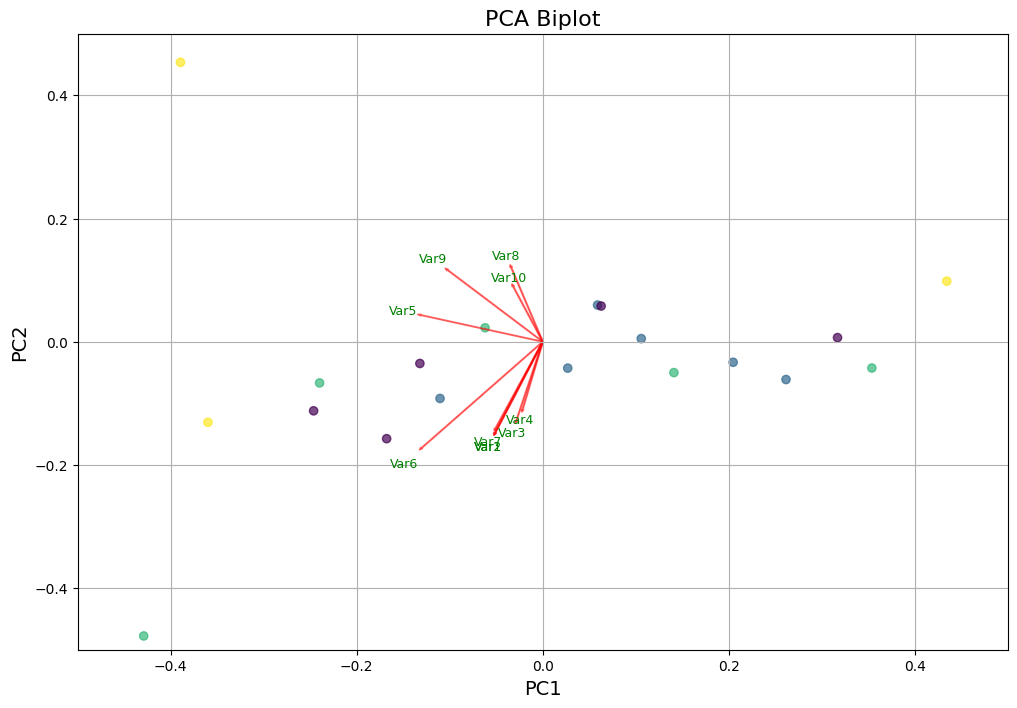

PCs explained variance:
PC1: 23.02%
PC2: 15.73%
PC3: 12.03%


,PC1,PC1_Loading,PC2,PC2_Loading,PC3,PC3_Loading
0,f3_clean_vel_pospeak_n,-0.227090,f3_clean_vel_pospeak_mean,-0.249509,CoG_integral,-0.294560
1,f3_clean_pospeak_n,-0.225100,f0_Gstd,0.245291,CoG_pospeak_std,0.279256
2,f2_clean_vel_pospeak_n,-0.223553,f0_pospeak_n,0.244768,CoG_pospeak_n,0.274855
3,f2_clean_vel_range,-0.209338,f0_range,0.240540,envelope_change_Gmean,0.254844
4,f2_clean_Gstd,-0.207581,f3_clean_vel_pospeak_std,0.205998,CoG_Gmean,-0.250294
5,f1_clean_vel_range,-0.204405,f3_clean_pospeak_mean,0.202094,CoG_range,0.248384
6,f1_clean_range,-0.203867,envelope_integral,-0.172313,f1_clean_pospeak_mean,-0.226109
7,f2_clean_range,-0.201218,f2_clean_vel_pospeak_mean,-0.169850,envelope_change_integral,0.219129
8,f2_clean_pospeak_n,-0.199212,f1_clean_vel_integral,-0.165138,CoG_Gstd,0.218615
9,VSA_f1f2,-0.198116,f2_clean_integral,0.165138,f2_clean_vel_pospeak_std,0.212810


In [ ]:
# Perform PCA analysis
results_df_voc = pca_analysis(voc_clean)

# Display
results_df_voc.head(20)

<br>
Now we save contributors as a file

In [18]:
# Save top contributors
results_df_voc.to_csv(curfolder + '\\datasets\\PCA_top_contributors_voc.csv', index=False)

# Save clean data
voc_clean.to_csv(curfolder + '\\datasets\\voc_clean_df.csv', index=False)

# PCA: Combined

Now we do the same for combined condition

In [19]:
# These are answer related columns
conceptcols = ['answer', 'expressibility', 'response']

# Concatenate both lists
colstodel = conceptcols 

# Clean the df
multi_clean = clean_df(data_multi, colstodel)

multi_clean.head(15)

,arm_duration,arm_inter_Kin,arm_inter_IK,arm_bbmv,lowerbody_duration,lowerbody_inter_Kin,lowerbody_inter_IK,lowerbody_bbmv,leg_duration,leg_inter_Kin,...,f2_clean_pospeak_std,f1_clean_pospeak_std,f1_clean_vel_pospeak_std,CoG_Gmean,CoG_Gstd,CoG_pospeak_mean,CoG_pospeak_std,CoG_integral,CoG_range,correction_info
0,3988.0,26.197,26.728,8.472,2020.0,26.580,26.181,5.400,2020.0,26.759,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c0
1,3868.0,26.674,28.122,8.148,2870.0,28.319,28.291,6.487,2870.0,27.096,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c1
2,4014.0,26.449,27.565,8.465,874.0,23.434,23.040,2.861,874.0,22.945,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c2
3,4046.0,26.207,28.558,8.482,3750.0,28.421,28.796,6.124,3750.0,27.973,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c0
4,4708.0,26.502,28.717,8.309,4508.0,29.760,28.762,6.005,4508.0,28.679,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c1
5,4004.0,26.978,28.554,8.699,3598.0,28.801,28.616,5.723,3598.0,28.179,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c2
6,0.0,0.000,0.000,0.000,784.0,23.222,22.753,2.313,784.0,22.135,...,0.867,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c0
7,5248.0,28.973,31.658,10.919,4930.0,28.905,29.800,14.893,4930.0,28.250,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c0
8,1784.0,25.011,24.190,6.604,0.0,0.000,0.000,0.000,0.0,0.000,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c1
9,1284.0,24.278,24.516,5.054,1334.0,25.381,25.483,4.317,1334.0,24.478,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,c2


<br>
Now we can use the function to perform the same PCA analysis but all (i.e., both vocal and gestural) features

Biplot for the first 2 PCs:


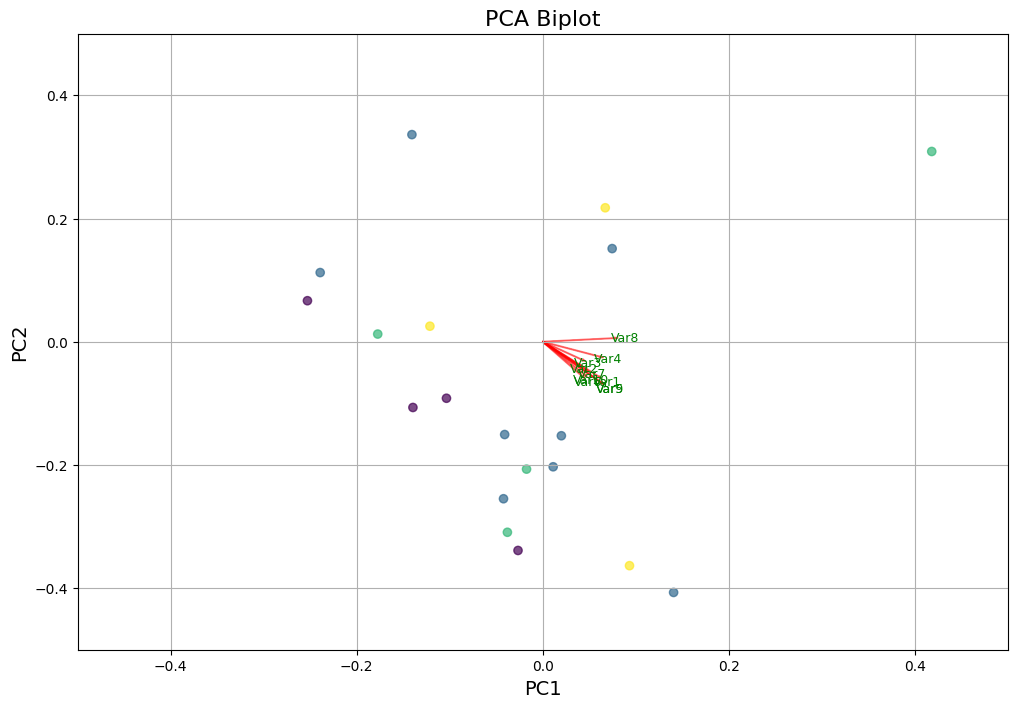

PCs explained variance:
PC1: 32.33%
PC2: 12.86%
PC3: 8.72%


,PC1,PC1_Loading,PC2,PC2_Loading,PC3,PC3_Loading
0,lowerbody_speedKin_sum_range,0.084947,pelvis_moment_sum_change_pospeak_n,-0.108598,pelvis_moment_sum_Gmean,-0.131078
1,lowerbody_speedKin_sum_Gstd,0.084128,lowerbody_moment_sum_change_pospeak_n,-0.102210,leg_moment_sum_change_pospeak_std,0.126453
2,lowerbody_accKin_sum_range,0.083025,envelope_change_range,-0.095835,pelvis_moment_sum_change_Gmean,0.125537
3,leg_angAcc_sum_range,0.082578,leg_moment_sum_pospeak_n,-0.095587,pelvis_moment_sum_integral,-0.125378
4,bbmv_total,0.082215,leg_angAcc_sum_pospeak_mean,0.095287,leg_moment_sum_change_pospeak_mean,0.123384
5,leg_angJerk_sum_range,0.082004,leg_angSpeed_sum_pospeak_mean,0.095287,lowerbody_jerkKin_sum_pospeak_mean,0.120110
6,lowerbody_accKin_sum_Gstd,0.081860,lowerbody_moment_sum_change_pospeak_std,-0.090847,leg_moment_sum_change_pospeak_n,0.114781
7,leg_angSpeed_sum_range,0.081268,leg_moment_sum_pospeak_std,-0.090727,lowerbody_moment_sum_change_Gmean,0.114695
8,head_angJerk_sum_range,0.081148,envelope_change_pospeak_n,-0.090655,leg_moment_sum_change_Gmean,0.114310
9,head_angJerk_sum_Gstd,0.080572,f0_range,-0.090308,pelvis_moment_sum_pospeak_mean,-0.113300


In [20]:
# Perform PCA analysis
results_df_multi = pca_analysis(multi_clean)

# Display
results_df_multi.head(20)


In [21]:
# Save top contributors
results_df_multi.to_csv(curfolder + '\\datasets\\PCA_top_contributors_multi.csv', index=False)

# Save clean data
multi_clean.to_csv(curfolder + '\\datasets\\multi_clean_df.csv', index=False)

<br>
In the [XGBoost script](../08_Analysis_XGBoost/02_XGBoost_effortIndicators.qmd#sec-xgboost), we will combine the ranking from Principal Component Analysis with the ranking of cummulative importance to get most predictive features of effort from uncorrelated dimensions.